# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

**Цель** — компании «Не бит, не крашен» нужно привлечь новых клиентов с помощью сервиса определения рыночной стоимости автомобиля по запросу.

**Задача исследования** — построить модель машинного обучения для определения стоимости автомобиля.

**Исследование пройдёт в четыре этапа:**
 1. Загрузка и подготовка данных;
 2. Обучение моделей;
 3. Анализ моделей;
 4. Общий вывод.
 
*Примечания:* 
* Для оценки качества моделей используется метрика RMSE. Значение метрики RMSE должно быть меньше 2500;
* Критерии, которые важны заказчику:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.


## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [2]:
# сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

Данные для исследования получаем из файла `autos`:

In [3]:
# чтение файлов с данными и сохранение в df
try:
    df = pd.read_csv('datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
# получение первых пяти строк таблицы
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# получение общей информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Описание данных**

*Признаки:*
*	`DateCrawled` — дата скачивания анкеты из базы;
*	`VehicleType` — тип автомобильного кузова;
*	`RegistrationYear` — год регистрации автомобиля;
*	`Gearbox` — тип коробки передач;
*	`Power` — мощность (л. с.);
*	`Model` — модель автомобиля;
*	`Kilometer` — пробег (км);
*	`RegistrationMonth` — месяц регистрации автомобиля;
*	`FuelType` — тип топлива;
*	`Brand` — марка автомобиля;
*	`NotRepaired` — была машина в ремонте или нет;
*	`DateCreated` — дата создания анкеты;
*	`NumberOfPictures` — количество фотографий автомобиля;
*	`PostalCode` — почтовый индекс владельца анкеты (пользователя);
*	`LastSeen` — дата последней активности пользователя.

*Целевой признак:*
*	`Price` — цена (евро).

**Обработка пропусков**

In [6]:
# подсчёт доли пропусков 
display(df.isna().mean())

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В данных содержатся пропуски. Более всего пропущенных значений в столбце `NotRepaired` — 20%.

Ввиду отсутствия информации и возможности достоверно восстановить её заполним заглушкой `unknown` следующие столбцы: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`:

In [7]:
# замена пропусков на значение заглушку
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [8]:
# подсчёт доли пропусков 
display(df.isna().mean())

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Пропуски обработаны.

**Приведение данных к корректному типу**

In [9]:
display(df.sample())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
13735,2016-03-07 22:50:38,6499,bus,2006,manual,75,caddy,150000,11,petrol,volkswagen,unknown,2016-03-07 00:00:00,0,15345,2016-04-07 09:16:00


In [10]:
# получение информации о типах данных
display(df.dtypes)

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Приведем данные к корректному типу, а также чтобы сэкономить память и процессорное время при обработке данных изменим тип данных на более оптимальный:

In [11]:
# изменение типа данных на integer
df['Price'] = pd.to_numeric(df['Price'], downcast='integer')
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], downcast='integer')
df['Power'] = pd.to_numeric(df['Power'], downcast='integer')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], downcast='integer')
df['RegistrationMonth'] = pd.to_numeric(df['RegistrationMonth'], downcast='integer')
df['NumberOfPictures'] = pd.to_numeric(df['NumberOfPictures'], downcast='integer')
df['PostalCode'] = pd.to_numeric(df['PostalCode'], downcast='integer')

# изменение типа данных на datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# получение информации о типах данных
display(df.dtypes)

DateCrawled          datetime64[ns]
Price                         int16
VehicleType                  object
RegistrationYear              int16
Gearbox                      object
Power                         int16
Model                        object
Kilometer                     int32
RegistrationMonth              int8
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int32
LastSeen             datetime64[ns]
dtype: object

Данные приведены к корректному типу.

**Поиск и обработка дубликатов**

In [13]:
# подсчет явных дубликатов
print("Явных дубликатов в df:", df.duplicated().sum())

Явных дубликатов в df: 4


В колонках содержатся дубликаты — обработаем их:

In [14]:
# удаление дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [15]:
# подсчет явных дубликатов
print("Явных дубликатов в df:", df.duplicated().sum())

Явных дубликатов в df: 0


Дубликаты удалены.

**Поиск аномалий в данных**

In [16]:
# числовое описание данных
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,3.543650e+05,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,6.354465e+09,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,3.782722e+12,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000e+00,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000e+00,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000e+00,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000e+00,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2.251800e+15,99998.000000


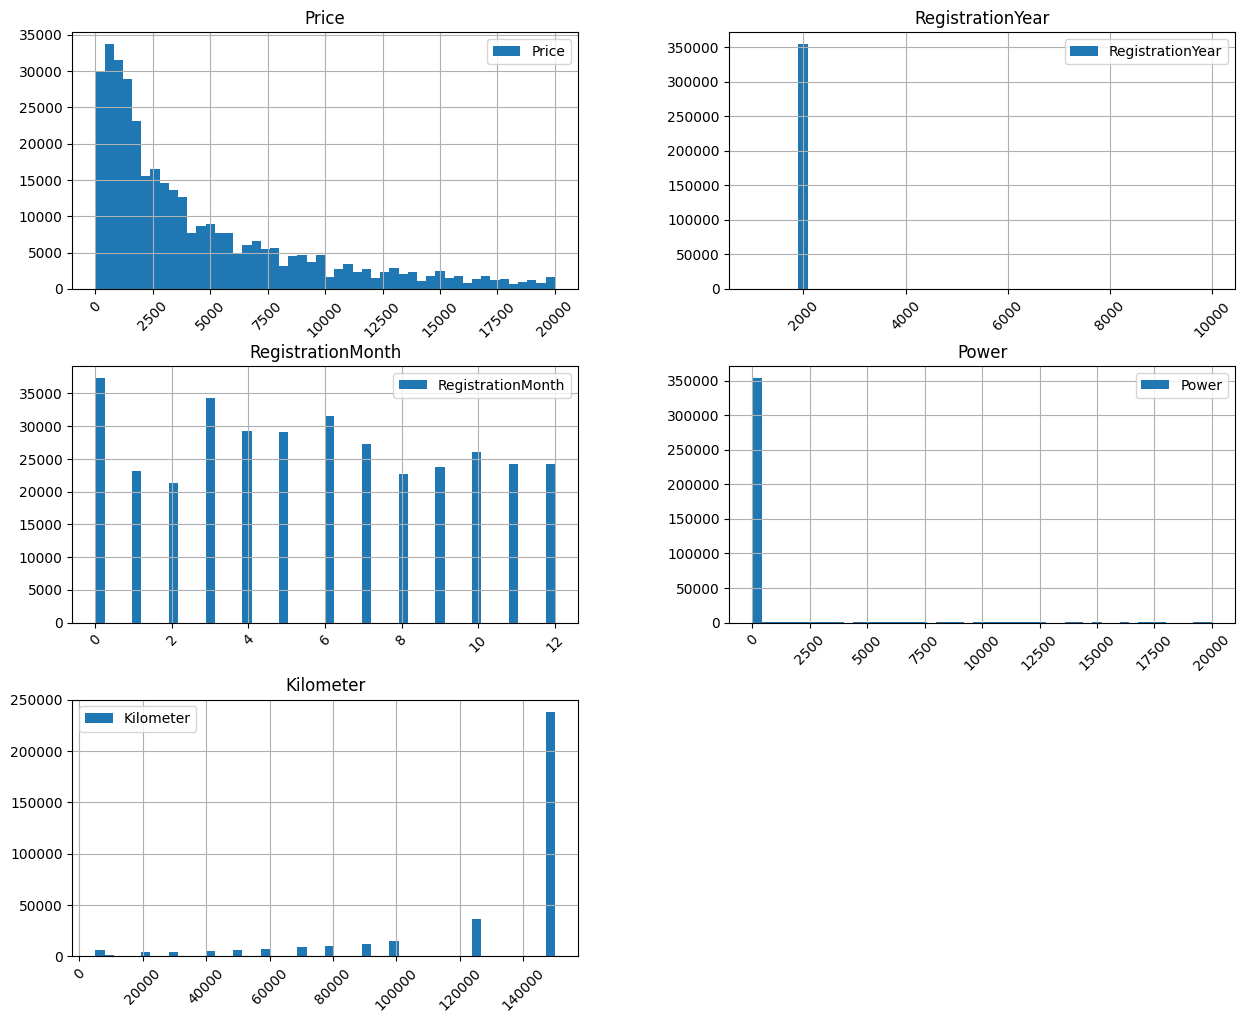

In [17]:
# графики распределения
df.hist(column=['Price', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer'], bins=50,
        figsize=(15,12), legend=True, xrot=45);

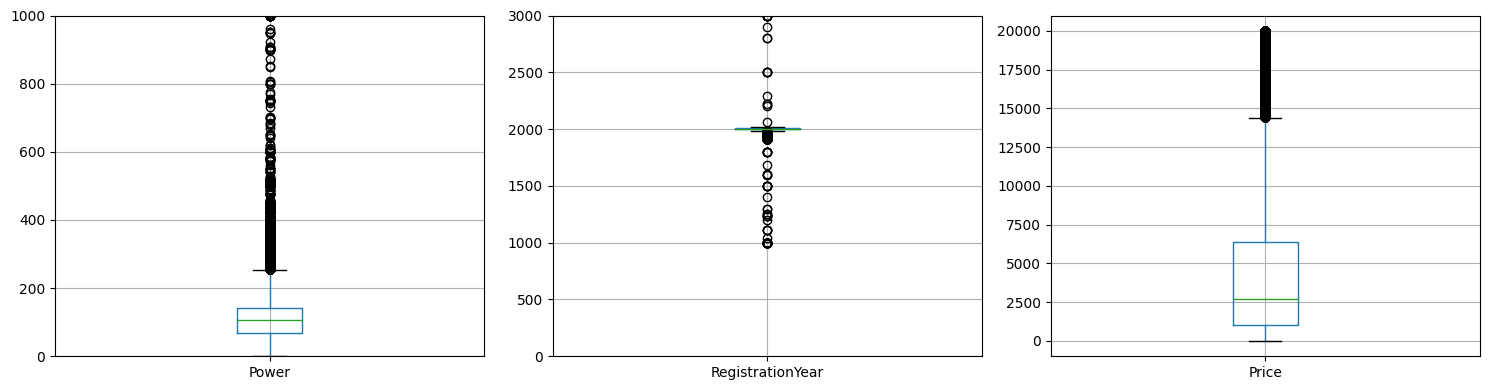

In [18]:
# настройка подложки
plt.figure(figsize=(15, 4))

# диаграммы размаха
plt.subplot(1,3,1)
df.boxplot(column='Power');
plt.ylim(0, 1000)

plt.subplot(1,3,2)
df.boxplot(column='RegistrationYear');
plt.ylim(0, 3000)

plt.subplot(1,3,3)
df.boxplot(column='Price');
plt.tight_layout()

По итогам анализа данных обработаем следующие аномалии:
* В `NumberOfPictures` (количество фотографий автомобиля) содержатся только нулевые значения — удалим столбец как неинформативный;
* Удалим колонки содержащие информацию бесполезную для целей предсказания стоимости автомобиля: `DateCrawled` (дата скачивания анкеты из базы), `DateCreated` (дата создания анкеты), `PostalCode` (почтовый индекс ),`LastSeen` (дата последней активности пользователя);
* Столбец `RegistrationYear` (год регистрации автомобиля) содержит выбросы — оставим в датафрейме данные свыше 1950 г. Кроме того, в данных содержатся строки с датой регистрации автомобиля свыше даты последней активности пользователя (2016 г.) — удалим и их;
* `RegistrationMonth` (месяц регистрации автомобиля) содержит нулевые значения — заполним заглушкой (-1);
* В колонке `Power` (мощность) содержатся выбросы, как нулевые, так и огромные значения — оставим в датасете автомобили с мощностью от 10 л.с. до 2000 л.с.
* Столбец `Price` содержит нулевые и слишком малые значения — удалим строки с ценой автомобиля менее 200 евро (~5% данных).

Перед началом корректировки данных сохраним оригинальны датафрейм:

In [19]:
df_raw = df.copy()

В данных содержатся строки с датой регистрации автомобиля свыше даты последней активности пользователя, удалим их:

In [20]:
# удалим строки с неккоректным годом регистрации автомобилей 
df = df.query('RegistrationYear <= LastSeen.dt.year.max()')

In [21]:
# проверка удаления
sum(df['RegistrationYear'] > df['LastSeen'].dt.year)/len(df)

0.0

In [22]:
# проверка на наличие автомобилей с месяцем регистрации свыше месяца последней активности пользователя (внутри года)
sum((df['RegistrationYear'] == df['LastSeen'].dt.year) & 
    (df['RegistrationMonth'] > df['LastSeen'].dt.month))/len(df)

0.014810128444686392

Удалим строки с месяцем регистрации автомобиля превышающем месяц последней активности пользователя внутри одного года:

In [23]:
# удаление строк с датой регистрации свыше даты последней активности пользователя
df = df.query('~((RegistrationYear == LastSeen.dt.year) & (RegistrationMonth > LastSeen.dt.month))')

Удалим строки с данными вне заданного диапазона значений:

In [24]:
# удаление строк с годом регистрации вне заданного диапазона
df = df.query('RegistrationYear >= 1950')

In [25]:
# удаление строк с мощностью вне заданного диапазона
df = df.query('(Power >= 10) & (Power <= 2000)')

In [26]:
# удаление строк с ценой вне заданного диапазона
df = df.query('Price >= 200')

Заменим нулевые значения на заглушку:

In [27]:
# замена нулевых значений в RegistrationMonth на заглушку
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = -1

В конце удалим колонки с излишними данными:

In [28]:
# удаление колонок с лишней или отсутствующей информацией
df.drop(["DateCrawled","DateCreated","NumberOfPictures", "PostalCode","LastSeen"], axis=1, inplace=True)

In [29]:
# получение первых пяти строк таблицы
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289205 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              289205 non-null  int16 
 1   VehicleType        289205 non-null  object
 2   RegistrationYear   289205 non-null  int16 
 3   Gearbox            289205 non-null  object
 4   Power              289205 non-null  int16 
 5   Model              289205 non-null  object
 6   Kilometer          289205 non-null  int32 
 7   RegistrationMonth  289205 non-null  int8  
 8   FuelType           289205 non-null  object
 9   Brand              289205 non-null  object
 10  NotRepaired        289205 non-null  object
dtypes: int16(3), int32(1), int8(1), object(6)
memory usage: 18.5+ MB


Посчитаем долю потерянных в результате предобработки данных:

In [31]:
print("Доля данных удаленных в результате предобработки:", '{:.0%}'.format(1-len(df)/len(df_raw)))

Доля данных удаленных в результате предобработки: 18%


Доля потерянной информации в рамках допустимого.

### Выводы

💡 В исходном файле содержатся данные о технических характеристиках, комплектации и ценах автомобилей. 

В ходе первичного анализа данных было выявлено:     

* В данных обнаружены пропуски — заполнены заглушкой `unknown` столбцы: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`;    
* Удалены явные дубликаты;     

* Данные были приведены к соответствующим типам;    

* Выявлены и обработаны аномалии: удалены столбцы с лишней или отсутствующей информацией; в столбцах `RegistrationYear` (год регистрации автомобиля), `Power` (мощность) и `Price` (цена) удалены строки и данными вне заданного диапазона; `RegistrationMonth` (месяц регистрации автомобиля) был заполнен заглушкой (-1).

## Обучение моделей

### Подготовка выборок

**Разделение данных на выборки**

In [32]:
# переменные для признаков и целевых признаков:
features = df.drop('Price',axis=1)
target = df['Price']

In [33]:
# получение первых пяти строк таблицы
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


Разделим данные на обучающую (60%), валидационную (20%) и тестовую (20%) выборки:

In [34]:
# разделение данных на обучающую, валидационную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features.copy(), target.copy(), 
                                                                             train_size=0.6, test_size=0.4, 
                                                                             random_state=12345)    

In [35]:
# разделение данных на обучающую, валидационную и тестовую выборки
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

In [36]:
print("Процент данных в обучающей выборке c признаками:", '{:.0%}'.format(len(features_train)/len(features)))
print("Процент данных в валидационной выборке c признаками:", '{:.0%}'.format(len(features_valid)/len(features)))
print("Процент данных в тестовой выборке c признаками", '{:.0%}'.format(len(features_test)/len(features)))

Процент данных в обучающей выборке c признаками: 60%
Процент данных в валидационной выборке c признаками: 20%
Процент данных в тестовой выборке c признаками 20%


In [37]:
print("Процент данных в обучающей выборке c целевыми признаками:", '{:.0%}'.format(len(target_train)/len(target)))
print("Процент данных в валидационной выборке c целевыми признаками:", '{:.0%}'.format(len(target_valid)/len(target)))
print("Процент данных в тестовой выборке c целевыми признаками:", '{:.0%}'.format(len(target_test)/len(target)))

Процент данных в обучающей выборке c целевыми признаками: 60%
Процент данных в валидационной выборке c целевыми признаками: 20%
Процент данных в тестовой выборке c целевыми признаками: 20%


**Прямое кодирование категориальных признаков (OHE)**

In [38]:
for _ in range(len(features.columns)):
    if features.iloc[:, _].dtypes == object:
        print(f'Количество уникальных категорий в {features.iloc[:, _].name}:', len(features.iloc[:, _].unique()))   

Количество уникальных категорий в VehicleType: 9
Количество уникальных категорий в Gearbox: 3
Количество уникальных категорий в Model: 250
Количество уникальных категорий в FuelType: 8
Количество уникальных категорий в Brand: 40
Количество уникальных категорий в NotRepaired: 3


💡 В столбцах `Model` и `Brand` содержится слишком много уникальных категориальных значений, поэтому преобразуем данные с помощью метода OE (Ordinal Encoding) для моделей на основе дерева решений. Для модели линейной регрессии закодируем данные с помощью метода прямого кодирования OHE (One-Hot Encoding) и отмасштабируем их.

In [39]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numerical = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [40]:
# трансформер для кодирования OHE и масштабирования данных
preprocessor_ohe = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical),
                                      ('num', MinMaxScaler(), numerical)
                                     ])
preprocessor_ohe.fit(features_train);

In [41]:
cat_columns_ohe = preprocessor_ohe.named_transformers_['cat'].get_feature_names_out(categorical)
columns_ohe = np.append(cat_columns_ohe, numerical)

print("******************** Training data ********************")
display(features_train.head())
display(pd.DataFrame(preprocessor_ohe.transform(features_train), columns=columns_ohe).head())

print()
print("******************** Test data ********************")
display(features_test.head())
display(pd.DataFrame(preprocessor_ohe.transform(features_test), columns=columns_ohe).head())

******************** Training data ********************


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
51511,bus,1997,manual,147,galaxy,150000,-1,unknown,ford,unknown
341977,wagon,1994,manual,115,astra,150000,-1,petrol,opel,no
220224,sedan,2007,manual,231,5er,150000,1,gasoline,bmw,no
188719,small,2006,manual,90,forfour,100000,9,petrol,smart,no
194929,wagon,2004,auto,131,passat,150000,1,gasoline,volkswagen,no


,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Gearbox_unknown,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_n


******************** Test data ********************


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
15488,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no
210904,small,1997,manual,60,polo,150000,10,petrol,volkswagen,no
124724,coupe,2010,manual,88,c4,100000,6,petrol,citroen,yes
46434,sedan,1998,auto,102,golf,125000,-1,petrol,volkswagen,yes
59756,sedan,2009,manual,143,1er,80000,1,petrol,bmw,no


,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Gearbox_unknown,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_n

**Порядковое кодирование категориальных признаков (OE)**

In [42]:
preprocessor_oe = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                      categorical)],
                                    remainder='passthrough')
preprocessor_oe.fit(features_train);

In [43]:
cat_columns_oe = preprocessor_oe.named_transformers_['cat'].get_feature_names_out(categorical)
columns_oe = np.append(cat_columns_oe, numerical)

print("******************** Training data ********************")
display(features_train.head())
display(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe).head())

print()
print("******************** Test data ********************")
display(features_test.head())
display(pd.DataFrame(preprocessor_oe.transform(features_test), columns=columns_oe).head())

******************** Training data ********************


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
51511,bus,1997,manual,147,galaxy,150000,-1,unknown,ford,unknown
341977,wagon,1994,manual,115,astra,150000,-1,petrol,opel,no
220224,sedan,2007,manual,231,5er,150000,1,gasoline,bmw,no
188719,small,2006,manual,90,forfour,100000,9,petrol,smart,no
194929,wagon,2004,auto,131,passat,150000,1,gasoline,volkswagen,no


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer,RegistrationMonth
0,0.0,1.0,112.0,7.0,10.0,1.0,1997.0,147.0,150000.0,-1.0
1,8.0,1.0,42.0,6.0,24.0,0.0,1994.0,115.0,150000.0,-1.0
2,4.0,1.0,15.0,2.0,2.0,0.0,2007.0,231.0,150000.0,1.0
3,5.0,1.0,105.0,6.0,32.0,0.0,2006.0,90.0,100000.0,9.0
4,8.0,0.0,170.0,2.0,38.0,0.0,2004.0,131.0,150000.0,1.0



******************** Test data ********************


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
15488,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no
210904,small,1997,manual,60,polo,150000,10,petrol,volkswagen,no
124724,coupe,2010,manual,88,c4,100000,6,petrol,citroen,yes
46434,sedan,1998,auto,102,golf,125000,-1,petrol,volkswagen,yes
59756,sedan,2009,manual,143,1er,80000,1,petrol,bmw,no


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer,RegistrationMonth
0,8.0,1.0,116.0,2.0,38.0,0.0,2013.0,184.0,60000.0,7.0
1,5.0,1.0,173.0,6.0,38.0,0.0,1997.0,60.0,150000.0,10.0
2,2.0,1.0,57.0,6.0,5.0,2.0,2010.0,88.0,100000.0,6.0
3,4.0,0.0,116.0,6.0,38.0,2.0,1998.0,102.0,125000.0,-1.0
4,4.0,1.0,6.0,6.0,2.0,0.0,2009.0,143.0,80000.0,1.0


**Определение параметров и функций**

Определим параметры и функцию для создания моделей:

In [44]:
parameters_LR = {}

parameters_DT = {'decisiontreeregressor__max_depth': list(range(1, 51))}

parameters_RF = {'randomforestregressor__max_depth': list(range(5, 56, 10)),
                }

parameters_LGBM = {'lgbmregressor__num_leaves': list(range(50, 301, 50)),
                 'lgbmregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
                  }
                   
parameters_CB = {'catboostregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                 'catboostregressor__iterations': [100, 200, 300]
                }

model_LR = make_pipeline(preprocessor_ohe, LinearRegression())
model_DT = make_pipeline(preprocessor_oe, DecisionTreeRegressor(random_state=12345))
model_RF = make_pipeline(preprocessor_oe, RandomForestRegressor(random_state=12345))
model_LGBM = make_pipeline(preprocessor_oe, LGBMRegressor(random_state=12345))
model_CB = make_pipeline(preprocessor_oe, CatBoostRegressor(random_state=12345, verbose = False)) 

In [45]:
def grid_search_cv(model, features_train, target_train, features_valid, parameters):
       
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='neg_root_mean_squared_error',
                        n_jobs=-1, error_score='raise')
    grid.fit(features_train, target_train)
    predictions = grid.best_estimator_.predict(features_valid)  
    
    rmse = mean_squared_error(target_valid, predictions)** 0.5
    
    print(f'RMSE:', round(rmse))
    print("Параметры лучшей модели:", grid.best_params_)
    print()

### Модель линейной регрессии

In [46]:
%%time
#обучение модели
grid_search_cv(model_LR, features_train, target_train, features_valid, parameters_LR)

RMSE: 2651
Параметры лучшей модели: {}

CPU times: total: 10.7 s
Wall time: 12.6 s


### Модель дерева решений

In [47]:
%%time
#обучение модели
grid_search_cv(model_DT, features_train, target_train, features_valid, parameters_DT)

RMSE: 1896
Параметры лучшей модели: {'decisiontreeregressor__max_depth': 13}

CPU times: total: 19.3 s
Wall time: 27.3 s


### Модель случайного леса

In [48]:
%%time
#обучение модели
grid_search_cv(model_RF, features_train, target_train, features_valid, parameters_RF)

RMSE: 1582
Параметры лучшей модели: {'randomforestregressor__max_depth': 25}

CPU times: total: 43.7 s
Wall time: 2min 59s


### Модель LightGBM

In [49]:
%%time
#обучение модели
grid_search_cv(model_LGBM, features_train, target_train, features_valid, parameters_LGBM)

RMSE: 1512
Параметры лучшей модели: {'lgbmregressor__learning_rate': 0.2, 'lgbmregressor__num_leaves': 300}

CPU times: total: 25.1 s
Wall time: 33.3 s


### Модель CatBoost

In [50]:
%%time
#обучение модели
grid_search_cv(model_CB, features_train, target_train, features_valid, parameters_CB)

RMSE: 1587
Параметры лучшей модели: {'catboostregressor__iterations': 300, 'catboostregressor__learning_rate': 0.4}

CPU times: total: 36.1 s
Wall time: 1min 20s


💡 Обучены 5 регрессионных моделей с наилучшими гиперпараметрами согласно скорингу RMSE.

## Анализ моделей

Проверим врямя работы моделей с лучшими параметрами на валидационной выборке:

### Модель линейной регрессии

In [51]:
# получение времени обучения и предсказания на лучших параметрах
model = LinearRegression()

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_ohe.transform(features_train), columns=columns_ohe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_ohe.transform(features_valid), columns=columns_ohe))

print()
RMSE_LR = round(mean_squared_error(target_valid, predictions) ** 0.5,)
print("RMSE:", RMSE_LR)

Время обучения:
CPU times: total: 8.98 s
Wall time: 2.59 s

Время предсказания:
CPU times: total: 719 ms
Wall time: 180 ms

RMSE: 2651


### Модель дерева решений

In [52]:
# получение времени обучения и предсказания на лучших параметрах
model = DecisionTreeRegressor(max_depth=13, random_state=12345)

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_oe.transform(features_valid), columns=columns_oe))

print()
RMSE_DT = round(mean_squared_error(target_valid, predictions) ** 0.5,)
print("RMSE:", RMSE_DT)

Время обучения:
CPU times: total: 562 ms
Wall time: 571 ms

Время предсказания:
CPU times: total: 78.1 ms
Wall time: 82 ms

RMSE: 1896


### Модель случайного леса

In [53]:
# получение времени обучения и предсказания на лучших параметрах
model = RandomForestRegressor(max_depth=25, random_state=12345)

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_oe.transform(features_valid), columns=columns_oe))

print()
RMSE_RF = round(mean_squared_error(target_valid, predictions) ** 0.5,)
print("RMSE:", RMSE_RF)

Время обучения:
CPU times: total: 39.4 s
Wall time: 39.5 s

Время предсказания:
CPU times: total: 1.42 s
Wall time: 1.42 s

RMSE: 1582


### Модель LightGBM

In [54]:
# получение времени обучения и предсказания на лучших параметрах
model = LGBMRegressor(learning_rate=0.2, num_leaves=300, random_state=12345)

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_oe.transform(features_valid), columns=columns_oe))

print()
RMSE_LGBM = round(mean_squared_error(target_valid, predictions) ** 0.5,)
print("RMSE:", RMSE_LGBM)

Время обучения:
CPU times: total: 13.2 s
Wall time: 1.47 s

Время предсказания:
CPU times: total: 1.62 s
Wall time: 139 ms

RMSE: 1512


### Модель CatBoost

In [55]:
# получение времени обучения и предсказания на лучших параметрах
model = CatBoostRegressor(learning_rate=0.4, iterations=300, random_state=12345, verbose = False)

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_oe.transform(features_valid), columns=columns_oe))

print()
RMSE_CB = round(mean_squared_error(target_valid, predictions) ** 0.5,)
print("RMSE:", RMSE_CB)

Время обучения:
CPU times: total: 28.2 s
Wall time: 3.27 s
Parser   : 156 ms

Время предсказания:
CPU times: total: 78.1 ms
Wall time: 82 ms

RMSE: 1587


### Итоги анализа и выбор лучшей модели

In [56]:
# итоги анализа моделей
results_analysis = pd.DataFrame({'RMSE': [RMSE_LR, RMSE_DT, RMSE_RF, RMSE_LGBM, RMSE_CB],
                        'Время обучения (сек.)': [2.59, 0.57, 39.6, 1.43, 3.36],
                        'Время предсказания (сек.)': [0.19, 0.08, 1.45, 0.15, 0.08]},
                        index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM', 'CatBoost'])
display(results_analysis)

,RMSE,Время обучения (сек.),Время предсказания (сек.)
Линейная регрессия,2651,2.59,0.19
Дерево решений,1896,0.57,0.08
Случайный лес,1582,39.60,1.45
LightGBM,1512,1.43,0.15
CatBoost,1587,3.36,0.08


In [57]:
# скоринг моделей
score_RMSE = 1 - (results_analysis['RMSE'] - results_analysis['RMSE'].min()
                 )/(results_analysis['RMSE'].max() - results_analysis['RMSE'].min())

score_time_fit = 1-(results_analysis['Время обучения (сек.)'] - results_analysis['Время обучения (сек.)'].min()
                   )/(results_analysis['Время обучения (сек.)'].max() - results_analysis['Время обучения (сек.)'].min())

score_time_pred = 1 - (results_analysis['Время предсказания (сек.)'] - 
                       results_analysis['Время предсказания (сек.)'].min()
                      )/(results_analysis['Время предсказания (сек.)'].max() - 
                         results_analysis['Время предсказания (сек.)'].min())

score_model = (score_RMSE + score_time_fit + score_time_pred)/3

results_scoring = pd.DataFrame({'score_RMSE': score_RMSE,
                        'score_time_fit': score_time_fit,
                        'score_time_pred': score_time_pred,
                        'score_model': score_model},
                        index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM', 'CatBoost'])

display(round(results_scoring, 2))

,score_RMSE,score_time_fit,score_time_pred,score_model
Линейная регрессия,0.00,0.95,0.92,0.62
Дерево решений,0.66,1.00,1.00,0.89
Случайный лес,0.94,0.00,0.00,0.31
LightGBM,1.00,0.98,0.95,0.98
CatBoost,0.93,0.93,1.00,0.95


**Согласно скорингу по трём параметрам (RMSE, время обучения, время предсказания) с условием равновесности лучшей, моделью признается LightGBM.**

### Тестирование лучшей модели

In [58]:
model = LGBMRegressor(learning_rate=0.2, num_leaves=300, random_state=12345)

print("Время обучения:")
%time model.fit(pd.DataFrame(preprocessor_oe.transform(features_train), columns=columns_oe), target_train)

print()
print("Время предсказания:")
%time predictions = model.predict(pd.DataFrame(preprocessor_oe.transform(features_test), columns=columns_oe))

print()
RMSE_LGBM_test = round(mean_squared_error(target_test, predictions) ** 0.5,)
print("RMSE:", RMSE_LGBM_test)

Время обучения:
CPU times: total: 12.2 s
Wall time: 1.25 s

Время предсказания:
CPU times: total: 1.66 s
Wall time: 138 ms

RMSE: 1515


In [60]:
# итоги теста модели
results_test = pd.DataFrame({'RMSE': [RMSE_LGBM_test],
                        'Время обучения (сек.)': '1.25',
                        'Время предсказания (сек.)': '0.138'},
                        index=['LightGBM'])
display(results_test)

,RMSE,Время обучения (сек.),Время предсказания (сек.)
LightGBM,1515,1.25,0.138


💡 В результате проверки на валидационной выборке выявлена модель с лучшим показателем RMSE — LightGBM (1512), при этом Случайный лес и CatBoost показывают схожие результаты по RMSE (1582 и 1587 соответственно). Однако модель Случайного леса находятся в аутсайдерах по времени обучения (39,6 сек.) и времени предсказания (1,45 сек.). LightGBM лучше в скорости обучения (1,43 сек.), чем CatBoost (3.36 сек.), однако немного медленнее в предсказании — 0.15 сек. против 0.08 сек. у CatBoost.    
Модели линейной регрессии и дерева решений по целевой метрике RMSE показали результаты гораздо более слабые.      

Согласно скорингу по трем параметрам (с условием равновесности) лучшей моделью признана LightGBM. На тестовой выборке RMSE модели составило 1515, время обучения — 1.25 сек., время предсказания — 0.138 сек.

## Общий вывод

В ходе работы было выполнено:

* Загружены, изучены и подготовлены данные — удалены дубликаты, пропущенные значения заполнены заглушками или удалены, удалены лишние колонки, обработаны аномалии;
* Было обучено пять различных моделей с перебором гиперпараметров, в т.ч. две модели с градиентным бустингом (LightGBM и CatBoost);
* По результатам обучения выбраны наилучшие параметры моделей согласно метрике RMSE;
* Модели с лучшими параметрами проверены на длительность обучения и предсказания на валидационной выборке. В результате составлена таблица скоринга и выбрана наилучшая модель по трем параметрам (с условием равновесности) — LightGBM;
* В финальной проверке на тестовой выборке модель LightGBM показала RMSE на уровне 1515, время обучения — 1.25 сек., время предсказания — 0.138 сек.

**Таким образом, были протестированы различные модели машинного обучения и выбрана целевая перспективная модель (LightGBM) для определения стоимости автомобиля для клиентов компании «Не бит, не крашен».**